In [309]:
%pylab inline
n=15
m=120

Populating the interactive namespace from numpy and matplotlib


### Load Rascal RRR counts

In [310]:
r_bins = np.arange(35,185,10)

In [311]:
mu_all = np.linspace(-1,1,m+1)
mu_bins = 0.5*(mu_all[1:]+mu_all[:-1])
delta_m = mu_bins[1]-mu_bins[0]

In [330]:
for per in [False,True]:
    if per:
        RRR_raw=np.loadtxt('/mnt/store1/oliverphilcox/3PCF_RRR_per/RRR_counts_n%d_m%d_full.txt'%(n,m))
    else:
        RRR_raw=np.loadtxt('/mnt/store1/oliverphilcox/3PCF_RRR/RRR_counts_n%d_m%d_full.txt'%(n,m))

    RRR_counts = np.zeros([n,n,m])
    for i in range(len(RRR_raw)):
        bin_mu = i%m
        bin_a = (i//m)%n
        bin_b = (i//m)//n
        RRR_counts[bin_a,bin_b,bin_mu]=RRR_raw[i]/delta_m

    delta_r = r_bins[1]-r_bins[0]
    r_min = r_bins-delta_r/2
    n=len(r_min)
    min_r_bin = 4

    vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

    RRR_compress = np.zeros([n-min_r_bin,m])

    denom = np.zeros([n-min_r_bin])
    for b1 in range(min_r_bin,n):
        for b2 in range(0,b1-3):
            RRR_compress[b1-min_r_bin,:]+=RRR_counts[b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        RRR_compress[b1-min_r_bin,:]/=denom[b1-min_r_bin]

    if per:
        R_per = RRR_compress
    else:
        R_aper = RRR_compress

In [331]:
l_max=3
from scipy.special import legendre
R_aper_mult = np.zeros([len(R_aper),l_max+1])
for ell in range(l_max+1):
    this_leg = legendre(ell)(mu_bins)
    R_aper_mult[:,ell]=np.sum(this_leg*R_aper,axis=1)*(2.*ell+1.)/2.*(mu_bins[1]-mu_bins[0])

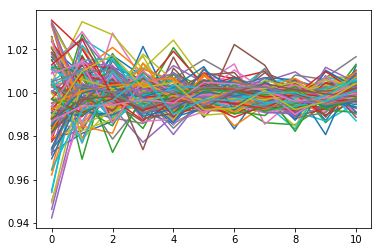

In [332]:
plt.plot(R_per/R_aper);


### Load SE RRR counts

In [610]:
for periodic in [True,False]:
    if periodic:
        rrr_file = '/home/oliverphilcox/3pcf_code/codes/grid_multipoles/qpm-random-small-period.out'
    else:
        rrr_file = '/home/oliverphilcox/3pcf_code/codes/grid_multipoles/qpm-random-small.out'
    n_bins = 18
    n_mult = 10

    import re,string

    start=False
    RRR_mult=np.zeros([n_bins,n_bins,n_mult+1])

    with open(rrr_file,"r") as xi_in:
        for line in xi_in:
            if not start:
                if(re.match("# Multipole power",line)):
                    start=True
                    continue
            if(re.match("# Total",line)):
                start=False
                continue
            if start:
                if(re.match("Multipole",line)):
                    continue
                strip_line = line.strip()
                if len(strip_line)==0:
                    continue
                split_line=strip_line.split()
                r1 = int(split_line[0])
                r2 = int(split_line[1])
                for i in range(n_mult+1):
                    RRR_mult[r1,r2,i]=split_line[int(i+2)]
                    if i>0:
                        RRR_mult[r1,r2,i]*=RRR_mult[r1,r2,0]
                    RRR_mult[r2,r1,i]=RRR_mult[r1,r2,i]
    RRR_mult=RRR_mult[3:,3:,:]

    delta_r = r_bins[1]-r_bins[0]
    r_min = r_bins-delta_r/2
    n=len(r_min)
    min_r_bin = 4

    vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

    RRR_compress_ras = np.zeros([n-min_r_bin,m])
    RRR_compress_SE = np.zeros([n-min_r_bin,n_mult+1])

    denom = np.zeros([n-min_r_bin])
    for b1 in range(min_r_bin,n):
        for b2 in range(0,b1-3):
            RRR_compress_ras[b1-min_r_bin,:]+=RRR_counts[b1,b2,:]*vol_r[b2]
            RRR_compress_SE[b1-min_r_bin,:]+=RRR_mult[b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        RRR_compress_ras[b1-min_r_bin,:]/=denom[b1-min_r_bin]
        RRR_compress_SE[b1-min_r_bin,:]/=denom[b1-min_r_bin]

    for ell in range(n_mult+1):
        RRR_compress_SE[:,ell]*=(2.*ell+1.)/2.
        
    from scipy.special import legendre
    RRR_compress_SE_mu = np.zeros([len(RRR_compress_SE),m])
    for b in range(len(RRR_compress_SE)):
        for l in range(n_mult+1):
            RRR_compress_SE_mu[b,:]+=legendre(l)(mu_bins)*RRR_compress_SE[b,l]

    if periodic:
        R_per = RRR_compress_SE_mu
    else:
        R_aper=RRR_compress_SE_mu

In [611]:
RRR_mult[5,2]

array([ 1.77064500e+05,  1.72060852e+03,  1.28651879e+02,  5.76852591e+01,
        2.36252205e+01,  1.98430873e+01,  1.28650834e+01,  1.76071469e+01,
       -2.38287207e+01, -1.27794355e+01, -1.97398764e+01])

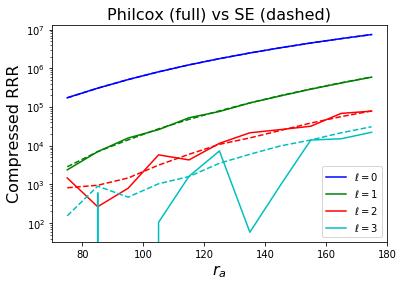

In [613]:
c=['b','g','r','c','y','k']
for ell in range(l_max+1):
    plt.plot(r_bins[min_r_bin:],R_aper_mult[:,ell],label=r'$\ell = %d$'%ell,c=c[ell])
    plt.plot(r_bins[min_r_bin:],6*RRR_compress_SE[:,ell],ls='--',c=c[ell])
plt.yscale('log')
plt.title('Philcox (full) vs SE (dashed)',fontsize=16)
plt.ylabel(r'Compressed RRR',fontsize=16)
plt.xlabel(r'$r_a$',fontsize=16)
plt.legend();

In [595]:
r_bins.shape

(15,)

(0, 2)

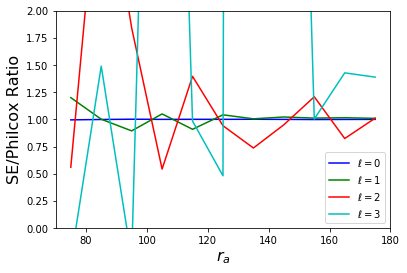

In [604]:
c=['b','g','r','c','y','k']
for ell in range(l_max+1):
    plt.plot(r_bins[min_r_bin:],6*RRR_compress_SE[:,ell]/R_aper_mult[:,ell],label=r'$\ell = %d$'%ell,c=c[ell])
plt.legend();
plt.ylabel('SE/Philcox Ratio',fontsize=16);
plt.xlabel(r'$r_a$',fontsize=16);
plt.ylim([0,2])

## Try estimating RRR multipoles directly in my code

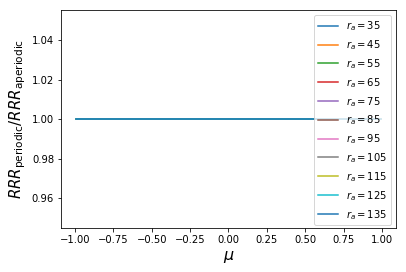

In [597]:
for i in range(len(R_per)):
    plt.plot(mu_bins,R_aper[i]/R_per[i],label=r'$r_a=%d$'%r_bins[i])
plt.ylabel(r'$RRR_\mathrm{periodic}/RRR_\mathrm{aperiodic}$',fontsize=15)
plt.xlabel(r'$\mu$',fontsize=16);
plt.legend()

### NB: Both algorithms work identically for non-periodic boundary conditions and a box with periodic grid much bigger than survey
### Also the two algorithms are identical for periodic boundary conditions... Maybe try a periodic box with larger grid to stop it being periodic?

## Compare results

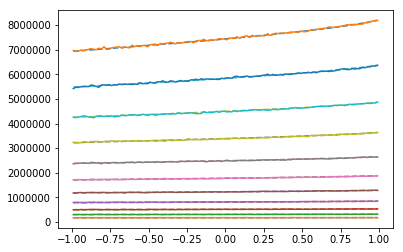

In [601]:
plt.plot(mu_bins,6.*RRR_compress_SE_mu.T,ls='--')
plt.plot(mu_bins,RRR_compress_ras.T);

Text(0.5,0,'$\\mu$')

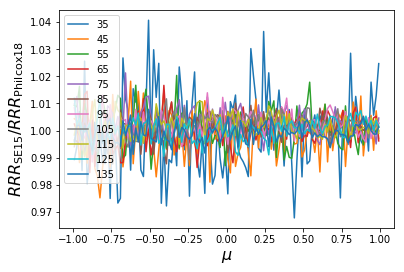

In [602]:
for i in range(len(RRR_compress_ras)):
    plt.plot(mu_bins,6*R_aper[i]/RRR_compress_ras[i],label=r'%d'%r_bins[i]);
plt.legend();
plt.ylabel(r'$RRR_\mathrm{SE15}/RRR_\mathrm{Philcox18}$',fontsize=16)
plt.xlabel(r'$\mu$',fontsize=16)

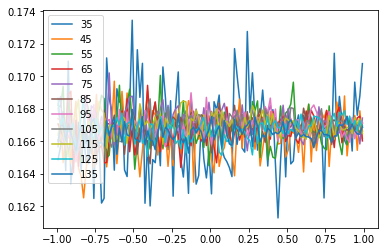

In [603]:
for i in range(len(RRR_compress_ras)):
    plt.plot(mu_bins,RRR_compress_SE_mu[i]/RRR_compress_ras[i],label=r'%d'%r_bins[i]);
plt.legend();

Create minute dataset

In [552]:
boxside = 1000
n_rand = int(200000)
w = np.ones([n_rand,1])
rand_par = np.random.uniform(size=(n_rand,3))*boxside
rand_all = np.hstack([rand_par,w])
new_rand = []
for rand in rand_all:
    if rand[0]+rand[1]<457:
        if rand[1]+np.sqrt(rand[2])>350:
            if rand[0]+np.sqrt(rand[0]*rand[1]+rand[2])<400:
                    new_rand.append(rand)
new_rand = np.asarray(new_rand)

In [553]:
len(new_rand)

1702

In [554]:
np.savetxt('/mnt/store1/oliverphilcox/3PCF_test/aperiodic_rand_small.txt',new_rand)

## Brute force pair counts:

In [619]:
def vec_norm(vec):
    return np.sqrt(vec[:,0]**2+vec[:,1]**2+vec[:,2]**2)

monopole=0
dipole=0
quadrupole=0
for rand in new_rand:
    all_norm = vec_norm(rand-new_rand)
    
    zero_filt = np.where(all_norm>0)
    all_norm = all_norm[zero_filt]
    
    # Do bin 1
    filt = np.where(all_norm<60.)
    filt2 = np.where(all_norm[filt]>=50.)
    
    # Do bin 2
    filt3 = np.where(all_norm<30.)
    filt4 = np.where(all_norm[filt3]>=20.)
    
    # Now find dipole
    diff2 = (new_rand[zero_filt][filt][filt2]-rand)[:,:3] ## j particles
    diff3 = (new_rand[zero_filt][filt3][filt4]-rand)[:,:3] ## k particles
    
    diff2/=vec_norm(diff2).reshape(-1,1)
    diff3/=vec_norm(diff3).reshape(-1,1)
    
    ## Define angles
    angs = diff3@diff2.T
    
    l2_angs = 0.5*(3.*angs**2-1.)
    
    monopole+=angs.shape[0]*angs.shape[1]#*(1./2.)*2
    dipole+=np.sum(angs)#*(2.*1.+1.)/2.*2
    quadrupole+=np.sum(l2_angs)#*(2.*2.+1.)/2.*2

In [622]:
print("monpole: %.6e, dipole/monopole: %.6e, quadrupole/monopole: %.6e"\
      %(monopole,dipole/monopole,quadrupole/monopole))

monpole: 6.758340e+05, dipole/monopole: 9.034697e-02, quadrupole/monopole: 1.707715e-02
